# P of 2nd transaction

In [ ]:
from src.utils.bq import BQ
from google.cloud import bigquery

obs_end_date = '2025-08-29' 

bq = BQ()

TRANSACTION_QUERY = """
DECLARE obs_end_date DATE DEFAULT @obs_end_date;
WITH base AS (
  SELECT
    customer_id,
    CASE WHEN market = 'us' THEN 'US'
         WHEN market = 'uk' THEN 'UK'
         ELSE 'EU' END AS market,
    transaction_completed_datetime
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_state = 'COMPLETED'
    AND transaction_completed_datetime IS NOT NULL
) ,
first_two AS (
  SELECT
    customer_id,
    market,
    ARRAY_AGG(transaction_completed_datetime ORDER BY transaction_completed_datetime) AS txns
  FROM base
  GROUP BY customer_id, market
)
SELECT
  customer_id,
  market,
  EXTRACT(YEAR FROM DATE(txns[OFFSET(0)])) AS cohort_year,
  DATE(txns[OFFSET(0)]) AS first_txn_date,
  CASE WHEN ARRAY_LENGTH(txns) >= 2 THEN 1 ELSE 0 END AS event,
  CASE WHEN ARRAY_LENGTH(txns) >= 2 THEN
    DATE_DIFF(DATE(txns[OFFSET(1)]), DATE(txns[OFFSET(0)]), DAY)
  ELSE
    DATE_DIFF(obs_end_date, DATE(txns[OFFSET(0)]), DAY)
  END AS duration
FROM first_two;
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
    bigquery.ScalarQueryParameter('obs_end_date', 'DATE', obs_end_date)
])
dtypes = {
    'customer_id': 'int32',
    'market': 'string',
    'cohort_year': 'int32',
    'first_txn_date': 'datetime64[ns]',
    'event': 'int32',
    'duration': 'int32'
}
df = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

In [3]:
df.head()

,customer_id,market,cohort_year,first_txn_date,event,duration
0,830097,UK,2012,2012-10-26,1,749
1,828442,UK,2012,2012-11-07,1,146
2,830352,UK,2012,2012-11-07,1,1162
3,830456,UK,2012,2012-11-08,0,4677
4,821297,UK,2012,2012-12-14,1,266


<>:14: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\h'
/var/folders/6q/6rsf1x3d1k7fzrsyrjyf8wnc0000gp/T/ipykernel_34250/2765701064.py:14: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("Estimated probability of survival $\hat{S}(t)$")


Text(0.5, 0, 'Time $t$ (days)')

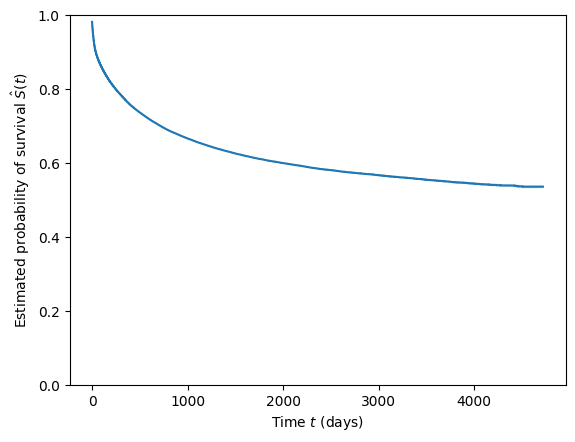

In [4]:
import matplotlib.pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    df["event"].astype(bool),
    df["duration"],
    conf_type="log-log"
)

plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], step="post", alpha=0.2)
plt.ylim(0, 1)
plt.ylabel("Estimated probability of survival $\hat{S}(t)$")
plt.xlabel("Time $t$ (days)")

# P of 2nd transaction within n months

In [18]:
from src.utils.bq import BQ
from google.cloud import bigquery

obs_end_date = '2025-08-29' 

bq = BQ()

TRANSACTION_QUERY = """
DECLARE obs_end_date DATE DEFAULT @obs_end_date;   -- e.g. '2025-08-29'
DECLARE horizon_months INT64 DEFAULT 16;           -- force failure at 16 months

WITH base AS (
  SELECT
    customer_id,
    CASE
      WHEN market = 'us' THEN 'US'
      WHEN market = 'uk' THEN 'UK'
      ELSE 'EU'
    END AS market,
    DATE(transaction_completed_datetime) AS txn_date
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_state = 'COMPLETED'
    AND transaction_completed_datetime IS NOT NULL
),

-- First and (distinct-day) second transaction per (customer, market)
first_two AS (
  SELECT
    customer_id,
    market,
    ARRAY_AGG(DISTINCT txn_date ORDER BY txn_date) AS txns
  FROM base
  GROUP BY customer_id, market
),

labels AS (
  SELECT
    customer_id,
    market,
    EXTRACT(YEAR FROM txns[OFFSET(0)]) AS cohort_year,
    txns[OFFSET(0)]                         AS first_txn_date,
    IF(ARRAY_LENGTH(txns) >= 2, txns[OFFSET(1)], NULL) AS second_txn_date,

    -- End of observation window for this customer (cap at 16 months)
    LEAST(
      obs_end_date,
      DATE_ADD(txns[OFFSET(0)], INTERVAL horizon_months MONTH)
    ) AS window_end
  FROM first_two
)

SELECT
  customer_id,
  market,
  cohort_year,
  first_txn_date,
  -- KM inputs:
  -- duration: time from first_txn_date to either event or censoring (days)
  CASE
    WHEN second_txn_date IS NOT NULL
         AND second_txn_date <= window_end
      THEN DATE_DIFF(second_txn_date, first_txn_date, DAY)   -- event at 2nd txn (≤ 16m)
    WHEN window_end = DATE_ADD(first_txn_date, INTERVAL horizon_months MONTH)
      THEN DATE_DIFF(window_end, first_txn_date, DAY)        -- forced event at 16m (no 2nd by then)
    ELSE DATE_DIFF(window_end, first_txn_date, DAY)          -- censored (insufficient follow-up)
  END AS duration,

  -- event: 1 = failure (i.e., “no longer surviving as 1×”), 0 = censored
  CASE
    WHEN second_txn_date IS NOT NULL
         AND second_txn_date <= window_end
      THEN 1                                                 -- second txn occurred in window
    WHEN window_end = DATE_ADD(first_txn_date, INTERVAL horizon_months MONTH)
      THEN 1                                                 -- forced failure at 16m with no 2nd
    ELSE 0                                                   -- censored before 16m
  END AS event
FROM labels;


"""

job_config = bigquery.QueryJobConfig(query_parameters=[
    bigquery.ScalarQueryParameter('obs_end_date', 'DATE', obs_end_date)
])
dtypes = {
    'customer_id': 'int32',
    'market': 'string',
    'cohort_year': 'int32',
    'first_txn_date': 'datetime64[ns]',
    'event': 'int32',
    'duration': 'int32'
}
df = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Text(0.5, 0, 'Time t (days)')

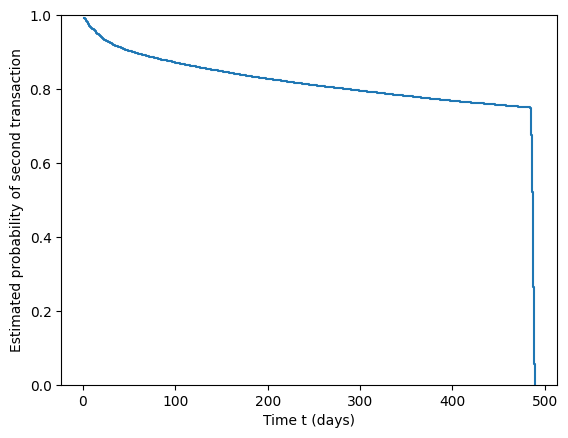

In [20]:
import matplotlib.pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    df["event"].astype(bool),
    df["duration"],
    conf_type="log-log"
)

plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], step="post", alpha=0.2)
plt.ylim(0, 1)
plt.ylabel("Estimated probability of second transaction")
plt.xlabel("Time t (days)")

# Remove customers with no 2nd transaction afrer n months

In [ ]:
from src.utils.bq import BQ
from google.cloud import bigquery

obs_end_date = '2025-08-29' 

bq = BQ()

TRANSACTION_QUERY = """
DECLARE obs_end_date DATE DEFAULT @obs_end_date;   -- e.g. '2025-08-29'
DECLARE horizon_months INT64 DEFAULT 16;           -- force failure at 16 months

WITH base AS (
  SELECT
    customer_id,
    CASE
      WHEN market = 'us' THEN 'US'
      WHEN market = 'uk' THEN 'UK'
      ELSE 'EU'
    END AS market,
    DATE(transaction_completed_datetime) AS txn_date
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_state = 'COMPLETED'
    AND transaction_completed_datetime IS NOT NULL
),

-- First and (distinct-day) second transaction per (customer, market)
first_two AS (
  SELECT
    customer_id,
    market,
    ARRAY_AGG(DISTINCT txn_date ORDER BY txn_date) AS txns
  FROM base
  GROUP BY customer_id, market
),

labels AS (
  SELECT
    customer_id,
    market,
    EXTRACT(YEAR FROM txns[OFFSET(0)]) AS cohort_year,
    txns[OFFSET(0)]                         AS first_txn_date,
    IF(ARRAY_LENGTH(txns) >= 2, txns[OFFSET(1)], NULL) AS second_txn_date,

    -- End of observation window for this customer (cap at 16 months)
    LEAST(
      obs_end_date,
      DATE_ADD(txns[OFFSET(0)], INTERVAL horizon_months MONTH)
    ) AS window_end
  FROM first_two
)

SELECT
  customer_id,
  market,
  cohort_year,
  first_txn_date,
  -- KM inputs:
  -- duration: time from first_txn_date to either event or censoring (days)
  CASE
    WHEN second_txn_date IS NOT NULL
         AND second_txn_date <= window_end
      THEN DATE_DIFF(second_txn_date, first_txn_date, DAY)   -- event at 2nd txn (≤ 16m)
    WHEN window_end = DATE_ADD(first_txn_date, INTERVAL horizon_months MONTH)
      THEN DATE_DIFF(window_end, first_txn_date, DAY)        -- forced event at 16m (no 2nd by then)
    ELSE DATE_DIFF(window_end, first_txn_date, DAY)          -- censored (insufficient follow-up)
  END AS duration,

  -- event: 1 = failure (i.e., “no longer surviving as 1×”), 0 = censored
  CASE
    WHEN second_txn_date IS NOT NULL
         AND second_txn_date <= window_end
      THEN 1                                                 -- second txn occurred in window
    WHEN window_end = DATE_ADD(first_txn_date, INTERVAL horizon_months MONTH)
      THEN 1                                                 -- forced failure at 16m with no 2nd
    ELSE 0                                                   -- censored before 16m
  END AS event
FROM labels;


"""

job_config = bigquery.QueryJobConfig(query_parameters=[
    bigquery.ScalarQueryParameter('obs_end_date', 'DATE', obs_end_date)
])
dtypes = {
    'customer_id': 'int32',
    'market': 'string',
    'cohort_year': 'int32',
    'first_txn_date': 'datetime64[ns]',
    'event': 'int32',
    'duration': 'int32'
}
df = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

In [ ]:
import matplotlib.pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    df["event"].astype(bool),
    df["duration"],
    conf_type="log-log"
)

plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], step="post", alpha=0.2)
plt.ylim(0, 1)
plt.ylabel("Estimated probability of second transaction")
plt.xlabel("Time t (days)")